In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

from pymbar import timeseries
from GPyOpt.methods import BayesianOptimization

sys.path.append("../code")

from tools.utils import get_data, trapezoid_integration, cubic_integration, work_json
from tools.multi_fidelity import MF, prep_mf_input
from tools.gaussian_process import GPR

from lammps.ethanol_water.automated.utils_automated import get_mean_sim_data_lo, train_gpr, g_lambda_i, adapted_distribution, get_partial_uncertanty, get_rmsd, \
                                                           estimate_variance, trackJobs, change_inputfile, change_jobfile, get_new_lambdas

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


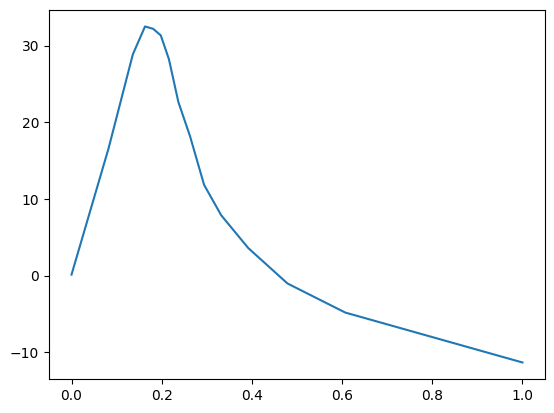

In [40]:
test = '/beegfs/work/st_163811/vle_using_solvation_free_energy/development/lammps/ethanol_water/opt_adapted/sim_lj_%d/fep_lj.fep'
paths     = [test%i for i in range(15)]
mean, var = get_mean_sim_data_lo(paths,15)

aa =  [0.0, 0.082, 0.136, 0.163, 0.181, 0.198, 0.216, 0.237, 0.263, 0.294, 0.332, 0.392, 0.479, 0.607, 1.0]
plt.plot(aa,mean)

In [44]:
aa[-2],mean[-2]

(0.607, -4.821868664641373)


Optimal uncertanty in each lambda step: 0.011

RMSD to optimal value: 127.95%

0.215

Optimal uncertanty in each lambda step: 0.005

RMSD to optimal value: 26.38%



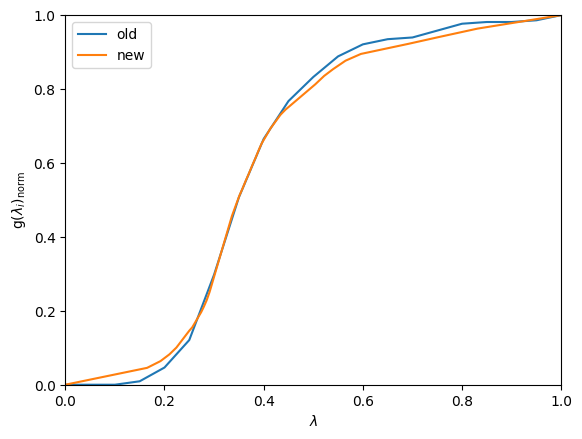

In [84]:
# try interpolation approach

# prentend seeing 21 datapoints

from scipy.interpolate import interp1d

# use MF and GPR model on current data to test this workflow, normaly one has to simulate each point iterated:

hf_inter  = interp1d(x_pred,m.flatten())
var_inter = interp1d(x_pred,v.flatten())

x_init = np.linspace(0,1,21)
y_init = hf_inter(x_init)
v_init = var_inter(x_init)

dG_i_inter = get_partial_uncertanty(x_init,v_init)

# Get rmsd to optimal variance

rmsd = get_rmsd(dG_i_inter,verbose=True)

grid = g_lambda_i(dG_i_inter)

print(grid[-1])
x_new = adapted_distribution(x_init,grid,50)
x_new[0] = 0.0

v_new = var_inter(x_new)

dG_i_new = get_partial_uncertanty(x_new,v_new)

grid_new = g_lambda_i(dG_i_new)

# Get rmsd to optimal variance

rmsd = get_rmsd(dG_i_new,verbose=True)

# Plot g_lambda_i

grid_new = np.array(grid_new)/max(grid_new)
grid     = np.array(grid)/max(grid)

plt.plot(x_init,grid,label="old")
plt.plot(x_new,grid_new,label="new")
plt.xlabel("$\lambda$")
plt.ylabel("g($\lambda_i$)$_\mathrm{norm}$")
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
plt.close()



Location: 0.268 --> predicted var: 0.502 ± 0.172 

Location: 0.215 --> predicted var: 0.170 ± 0.394 

Location: 0.415 --> predicted var: 0.417 ± 0.124 

Location: 0.532 --> predicted var: 0.104 ± 0.446 

Location: 0.731 --> predicted var: 0.013 ± 0.465 

Location: 0.270 --> predicted var: 0.569 ± 0.164 

Location: 0.278 --> predicted var: 0.833 ± 0.107 

Location: 0.273 --> predicted var: 0.639 ± 0.151 

Location: 0.950 --> predicted var: 0.002 ± 0.722 

Location: 0.940 --> predicted var: 0.001 ± 0.732 

Location: 0.914 --> predicted var: 0.000 ± 0.734 

Location: 0.885 --> predicted var: 0.000 ± 0.734 

Location: 0.843 --> predicted var: 0.000 ± 0.734 

Location: 0.050 --> predicted var: 0.000 ± 0.722 

Location: 0.632 --> predicted var: 0.001 ± 0.734 

Location: 0.140 --> predicted var: 0.003 ± 0.728 

Location: 0.796 --> predicted var: 0.004 ± 0.715 

Location: 0.357 --> predicted var: 1.068 ± 0.076 

Location: 0.470 --> predicted var: 0.117 ± 0.600 

Location: 0.947 --> predicted v

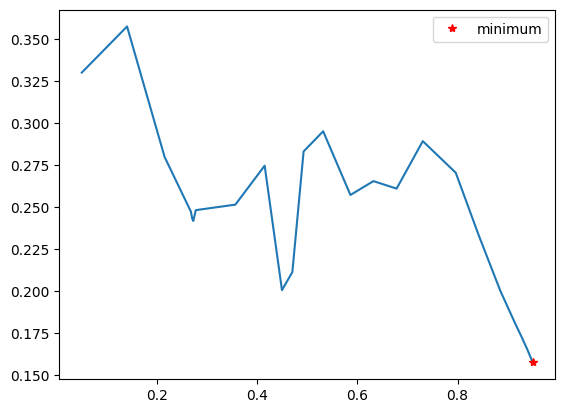

In [4]:
## BO to optimize grid points with the aim to equalize the variance of each delta_G_ij

def my_objective_function(x):
    
    var_dG_i = estimate_variance( x, gpr_modeling ,lambdas, var )

    ## Return RMSD for optimal variance in each window ##
    g_lambda_i = np.sum(var_dG_i)
    var_dG_opt = 1/(len(var_dG_i)-1) * g_lambda_i

    rmsd = np.mean( (np.array(var_dG_i) - var_dG_opt)**2 ) * 1/var_dG_opt *100
    
    return rmsd


domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.05,0.95)}]
bo     = BayesianOptimization( f=my_objective_function, domain=domain, exact_feval=True )

# Run the optimization just to search for the next intermediate 

## Mecklenfeld and Raabe did two iterative things: 
## first allow to add / remove one intermediate step and 2nd let the spacing vary

bo.run_optimization( max_iter=20 )

ins  = bo.get_evaluations()[0].flatten()
outs = bo.get_evaluations()[1].flatten()
idx  = np.argsort(ins)

for i,o in zip(ins[idx],outs[idx]):
    print("Tested point: %f --> resulted RMSD value [%%]: %.3f"%(i,o))

print("The minumum RMSD was %.3f (x = %.4f)" % (bo.fx_opt, bo.x_opt))

plt.plot(ins[idx],outs[idx])
plt.plot(bo.x_opt,bo.fx_opt,"r*",label="minimum")
plt.legend()
plt.show()

## 1D multifidelity with several low fidelities

Low fidelity keys found in database: ['butylamine_363', 'butylamine_373']


 /home/st/st_st/st_st163811/miniconda3/lib/python3.10/site-packages/GPy/core/__init__.py:80: FutureWarning:In the future `np.bool` will be defined as the corresponding NumPy scalar.


Scaling factor between low and high fidelity:  [0.9424690830788565, 1.123377813839056]


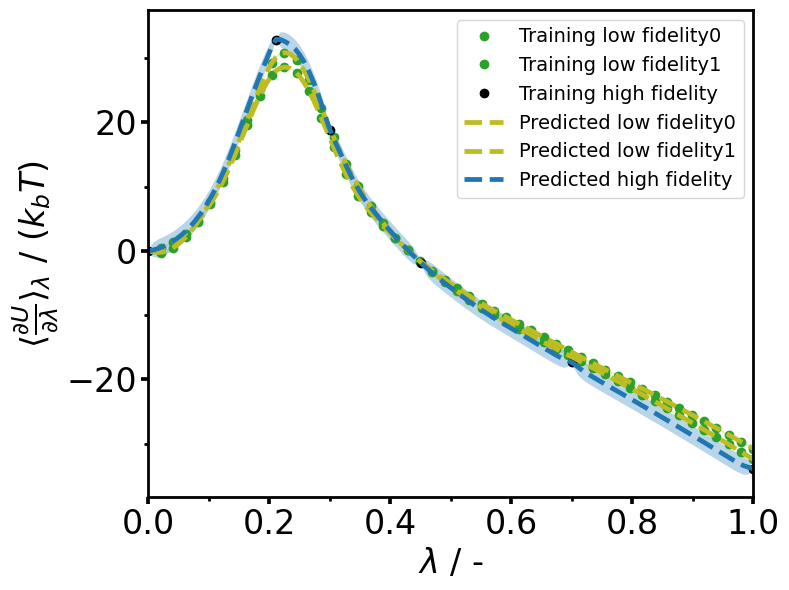

0.8038240836830555


In [3]:
# Butylamine 353
x_learn_h = [ 0.0, 0.1, 0.17, 0.21, 0.26, 0.3, 0.45, 0.7, 1.0 ]
y_learn_h = [ 4.54403794e-04,  7.65222599e+00,  2.32794516e+01,  3.28579411e+01,
        2.93576995e+01,  1.87869936e+01, -1.81865197e+00, -1.73555202e+01,
       -3.39313366e+01]

idx       = np.arange(9)
idx       = [0,3,5,6,7,8]

xinp = np.array(x_learn_h)[idx]
yinp = np.array(y_learn_h)[idx]

a,b,c = multifidelity(xinp,yinp,lf_dict={"lf_key":"vdW","lf_fluid":["butylamine_363","butylamine_373"]},print_out=True)

print( np.mean( np.abs((y_learn_h-interp1d(a,b)(x_learn_h)) / y_learn_h * 100 ) ))

# idx = [0,1,3,4,5,6,7,8]
# 3 mf --> 1.65% dev to all training data --> 11s exectuion time ["hexane_343","hexane_363","hexane_373"]

# idx = [0,2,3,4,5,6,7,8]
# 3 mf --> 1.33% dev to all training data --> 11s exectuion time ["hexane_343","hexane_363","hexane_373"]

# idx = [0,3,4,5,6,7,8]
# 3 mf --> 1.33% dev to all training data --> 11s exectuion time ["hexane_343","hexane_363","hexane_373"]

# idx = [0,3,5,6,7,8]
# 3 mf --> 1.7% dev to all training data --> 8s exectuion time ["hexane_343","hexane_363","hexane_373"]

Low fidelity keys found in database: ['hexane_343', 'hexane_363', 'hexane_373']


 /home/st/st_st/st_st163811/miniconda3/lib/python3.10/site-packages/GPy/core/__init__.py:80: FutureWarning:In the future `np.bool` will be defined as the corresponding NumPy scalar.


Scaling factor between low and high fidelity:  [0.9139151072892695, 0.936187821163421, 1.126273821854846]


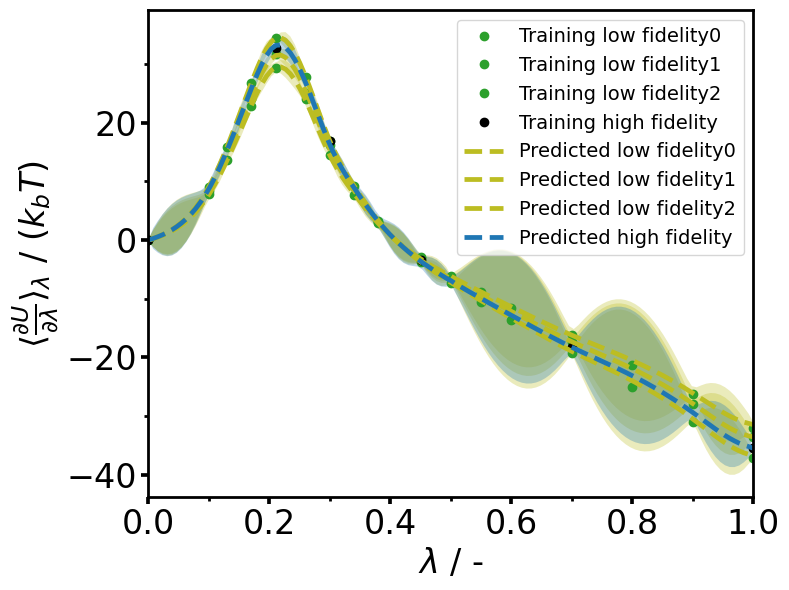

1.6834106037632361


In [33]:
# Hexane 353
x_learn_h = [ 0.0, 0.1, 0.17, 0.21, 0.26, 0.3, 0.45, 0.7, 1.0 ]
y_learn_h = [ 7.52158864e-04,  8.77906717e+00,  2.55531656e+01,  3.26998355e+01,
        2.68492535e+01,  1.68906530e+01, -3.34086334e+00, -1.82721430e+01,
       -3.55201688e+01]

idx       = np.arange(9)
idx       = [0,3,5,6,7,8]

xinp = np.array(x_learn_h)[idx]
yinp = np.array(y_learn_h)[idx]

a,b,c = multifidelity(xinp,yinp,lf_dict={"lf_key":"vdW","lf_fluid":["hexane_343","hexane_363","hexane_373"]},print_out=True)

print( np.mean( np.abs((y_learn_h-interp1d(a,b)(x_learn_h)) / y_learn_h * 100 ) ))

# idx = [0,1,3,4,5,6,7,8]
# 3 mf --> 1.65% dev to all training data --> 11s exectuion time ["hexane_343","hexane_363","hexane_373"]

# idx = [0,2,3,4,5,6,7,8]
# 3 mf --> 1.33% dev to all training data --> 11s exectuion time ["hexane_343","hexane_363","hexane_373"]

# idx = [0,3,4,5,6,7,8]
# 3 mf --> 1.33% dev to all training data --> 11s exectuion time ["hexane_343","hexane_363","hexane_373"]

# idx = [0,3,5,6,7,8]
# 3 mf --> 1.7% dev to all training data --> 8s exectuion time ["hexane_343","hexane_363","hexane_373"]

Low fidelity keys found in database: ['pentane_397', 'butane_343', 'hexane_343', 'hexane_373', 'butylamine_373']


 /home/st/st_st/st_st163811/miniconda3/lib/python3.10/site-packages/GPy/core/__init__.py:80: FutureWarning:In the future `np.bool` will be defined as the corresponding NumPy scalar.


Scaling factor between low and high fidelity:  [1.046374348126877, 1.6241071805427254, 0.854568165895612, 0.9657372761027953, 1.0878815360819267]


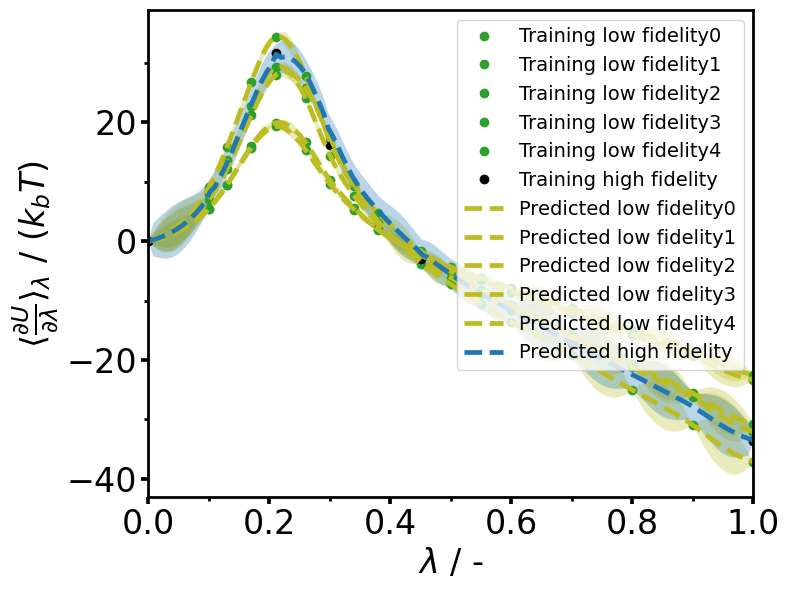

12.623429557011383


In [32]:
# Hexane 363
x_learn_h = [0.0,0.1,0.17,0.21,0.26,0.3,0.38,0.45,0.7,0.9,1.0]
y_learn_h = [0.00061303425,8.41056753,24.1262077,31.7049877,25.0255622,16.1566911,3.08786544,-3.017685,-17.3554071,-27.8978428,-33.5718558]

idx       = np.arange(11)
idx       = [0,1,2,3,4,5,7,8,10]
idx       = [0,1,3,5,7,8,10]

xinp = np.array(x_learn_h)[idx]
yinp = np.array(y_learn_h)[idx]

a,b,c = multifidelity(xinp,yinp,lf_dict={"lf_key":"vdW","lf_fluid":["pentane_*","butane_*","hexane_343","hexane_373","butylamine_373"]},print_out=True)

# idx = [0,1,2,3,4,5,7,8,10]
# 2 mf --> 9.7% dev to all training data --> 2s exectuion time ["hexane_373","butylamine_373"]
# 3 mf --> 4.6% dev to all training data --> 11s exectuion time ["hexane_343","hexane_373","butylamine_373"]
# 4 mf --> 14.3% dev to all training data --> 59s exectuion time ["butane_*","hexane_343","hexane_373","butylamine_373"]
# 5 mf --> 4.6% dev to all training data --> 98s exectuion time ["pentane_*","butane_*","hexane_343","hexane_373","butylamine_373"]

# idx = [0,1,3,5,7,8,10]
# 2 mf --> 8.7% dev to all training data --> 2s exectuion time ["hexane_373","butylamine_373"]
# 3 mf --> 13.2% dev to all training data --> 9s exectuion time ["hexane_343","hexane_373","butylamine_373"]
# 4 mf --> 14.1% dev to all training data --> 30s exectuion time ["butane_*","hexane_343","hexane_373","butylamine_373"]
# 5 mf --> 12.6% dev to all training data --> 51s exectuion time ["pentane_*","butane_*","hexane_343","hexane_373","butylamine_373"]

print( np.mean( np.abs((y_learn_h-interp1d(a,b)(x_learn_h)) / y_learn_h * 100 ) ))

In [29]:
import moleculegraph
import numpy as np
import toml
import json
from jinja2 import Template
import os
from scipy.constants import Avogadro,Boltzmann
import random
from utils import *

#### Name of the mixture everything will be created in this subfolder ####

Gruppe   = "Mixtures"

name_mix = "Propanethiol_butane"

#name1   = "butane"
#molecule_graphstring1 = "[CH3_alkane][CH2_alkane][CH2_alkane][CH3_alkane]"
#molecule1 = moleculegraph.molecule(molecule_graphstring1)

name1 = "propanethiol"
molecule_graphstring1 = "[CH3_alkane][CH2_alkane][CH2_thiol][SH_thiol][cH_thiol]"
molecule1 = moleculegraph.molecule(molecule_graphstring1)

name2 = "propanethiol1"
molecule_graphstring2 = "[CH3_alkane][CH2_alkane][CH2_thiol][SH_thiol][cH_thiol]"
molecule2 = moleculegraph.molecule(molecule_graphstring2)

#name2   = "butane1"
#molecule_graphstring2 = "[CH3_alkane][CH2_alkane][CH2_alkane][CH3_alkane]"
#molecule2 = moleculegraph.molecule(molecule_graphstring2)

#### Specify temperatures [K], pressures [bar] and mass densities [kg/m^3] ####
## Important: In mixture simulations, dont simulate x1=0.999 and x2=0.0001 because it should equal the pure simulation ##
## and can be disregarded. Therefore adapt temperature and density range when adding component one / two ##

# Equilibrium pressures and densities from SAFT (pressures double checked in comparison to experimental values)

# complete range: p   = [ 1.094, 2.143, 3.022, 3.775, 4.44 , 5.05 , 5.632, 6.209, 6.803, 7.431, 8.111 ]
# complete range: rho = [ 788.077, 760.408, 732.781, 705.218, 677.743, 650.382, 623.164, 596.122, 569.289, 542.705, 516.415 ]

temperatures  = [ 343.15, 343.15, 343.15, 343.15, 343.15, 343.15, 343.15, 343.15, 343.15, 343.15 ]
pressures     = [ 1.094 ]
densities     = [ 788.077 ]

ntotal        = 1200

x1            = np.array( [ 0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

nmols1        = (x1*ntotal).astype(int)
nmols2        = ntotal-nmols1

nmol_list_tot = [[n1,n2] for n1,n2 in zip(nmols1,nmols2)]

print("Molecule numbers species 1:",nmols1)
print("Molecule numbers species 2:",nmols2)

name      = "mix_%s_%s"%(name1,name2)
name_list = [name1,name2]
mol_list  = [molecule1,molecule2]

atom_numbers = list( np.arange(molecule1.atom_number+molecule2.atom_number) +1 )

Molecule numbers species 1: [   1  120  240  360  480  600  720  840  960 1080]
Molecule numbers species 2: [1199 1080  960  840  720  600  480  360  240  120]


In [30]:
# Create input force field file for playmol to build the system

# Load in the used ff 

input_file_name = "../force-fields/forcefield_lammps_UA_TAMie.toml"
input_file_name = "../force-fields/forcefield_lammps.toml"
#input_file_name = "../force-fields/forcefield_LJ.toml"
#input_file_name = "../force-fields/forcefield_OPLS_AA.toml"

with open(input_file_name) as toml_file:
    ff = toml.load(toml_file)

def get_name(name):
    if name[0] == "c":
        return name[1]
    else:
        return name[0]

playmol_atom_names = [j for sub in [[ get_name(mn) for mn in molecule.atom_names] for molecule in mol_list] for j in sub]
playmol_bond_names = [j for sub in [[ [ get_name( molecule.atom_names[mi]) for mi in bl ] for bl in molecule.bond_list]  for molecule in mol_list] for j in sub]

renderdict = {}

#Bestimmte die UA die im Molekül vorkommen und schreibe dict mit FF Paras
nonbonded                  = np.array([j for sub in [molecule.map_molecule( molecule.unique_atom_keys, ff["atoms"] ) for molecule in mol_list] for j in sub])
renderdict["nonbonded"]    = list(zip([j for sub in [molecule.unique_atom_keys for molecule in mol_list] for j in sub],nonbonded))

#Liste alle bonds mit zugehörigen FF Paras
bonds                      = [j for sub in [molecule.map_molecule( molecule.unique_bond_keys, ff["bonds"] ) for molecule in mol_list] for j in sub]
renderdict["bonds"]        = list(zip([j for sub in [molecule.unique_bond_names for molecule in mol_list] for j in sub],bonds))

#Liste alle angles mit zugehörigen FF Paras      
angles                     = [j for sub in [molecule.map_molecule( molecule.unique_angle_keys, ff["angles"] ) for molecule in mol_list] for j in sub]
renderdict["angles"]       = list(zip([j for sub in [molecule.unique_angle_names for molecule in mol_list] for j in sub],angles))

#Liste alle torsions mit zugehörigen FF Paras
torsions                   = [j for sub in [molecule.map_molecule( molecule.unique_torsion_keys, ff["torsions"] ) for molecule in mol_list] for j in sub]
renderdict["torsions"]     = list(zip([j for sub in [molecule.unique_torsion_names for molecule in mol_list] for j in sub],torsions))

#Generiere Playmol input style für bonds,angles,torsions via templates (using jinja2)

if not os.path.exists("../inout_playmol/"+name_mix+"/"+name+"/"):
    os.makedirs("../inout_playmol/"+name_mix+"/"+name+"/")

with open("../templates/template.playmol") as file_:
    template = Template(file_.read())
rendered = template.render( rd=renderdict )

with open("../inout_playmol/"+name_mix+"/"+name+"/"+name+".playmol", "w") as fh:
    fh.write(rendered) 

In [34]:
#### Define samples for coupling free energy calculation ####

## Adapt is one simulation file that adapts the lambda parameters during the simulation. Simulation run will be long ##
## Not adapt is n simulations each with a different lambda each runnining ...ns ##

adapt = True
adapt = False

# Which free energy method should be used. If TI then dU/dlambda will be sampled. If FEP then U(lambda_i+1) - U(lambda_i) will be sampled (can be used in FEP and BAR)

method = "TI"
#method = "FEP"

# Lennard-Jones simulation

txt_sim,sim_lj = "sim_lj",True

# Coulomb simulation

txt_sim,sim_lj = "sim_coul",False

### LENNARD-JONES LAMBDAS ###

if method == "TI":

    # Route 0 to 1 start at lambda=0.0 and end at lambda=1.0
    l_lj_01  = np.array( [ 0.0, 0.1, 0.13, 0.17, 0.21, 0.26, 0.3, 0.34, 0.38, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1.0] )

    # Route 1 to 0 start at lambda=1.0 and end at lambda=0.0
    l_lj_10 = np.flip( l_lj_01 )

    lambda_lj_sim  = [l_lj_01,l_lj_10]

    dl_lj_01,dl_lj_10 = [],[]

elif method == "FEP":

    # Route 0 to 1 start at lambda=0.0 and end at lambda=0.95
    # Sample in lambda=0.0 energy diff to lambda=0.1; sampte at lambda=0.95 energy diff to lambda=1.0

    l_lj_01  = np.array( [ 0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95 ] )
    dl_lj_01 = np.round( [l_lj_01[i+1]-a for i,a in enumerate(l_lj_01[:-1])] + [1.0-l_lj_01[-1]], 2 )

    # Route 1 to 0 start at lambda=1.0 and end at lambda=0.1
    # Sample in lambda=1.0 energy diff to lambda=0.95; sampte at lambda=0.01 energy diff to lambda=0.0

    l_lj_10  = np.array( [ 1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1 ] )
    dl_lj_10 = np.round( [l_lj_10[i+1]-a for i,a in enumerate(l_lj_10[:-1])] + [0.0-l_lj_10[-1]], 2 )


### ATOM CHARGE LAMBDAS ###

if method == "TI":
    
    # Route 0 to 1 start at lambda=0.002 and end at lambda=1.0
    l_q_01  = np.array( [ 0.002, 0.25, 0.5, 0.75, 1.0 ] )

    # Route 1 to 0 start at lambda=1.0 and end at lambda=0.002
    l_q_10  = np.flip( l_q_01 ) 

    dl_q_01,dl_q_10 = [],[]

elif method == "FEP":
    
    # Route 0 to 1 start at 0.002 and end at 0.8;
    # Sample at lambda=0.002 energy diff to lambda=0.2; sample in lambda=0.8 energy diff to lambda=1.0

    l_q_01  = np.array( [ 0.002, 0.2, 0.4, 0.6, 0.8 ] )
    dl_q_01 = np.round( [l_q_01[i+1]-a for i,a in enumerate(l_q_01[:-1])]+ [1.0-l_q_01[-1]], 2 ) 


    # Route 1 to 0 start at 1.0 and end at lambda=0.2; 
    # Sample at lambda=1.0 energy diff to lambda=0.8; sample at lambda=0.2 energy diff to lambda=0.002

    l_q_10  = np.array( [ 1.0, 0.8, 0.6, 0.4, 0.2 ] )
    dl_q_10 = np.round([l_q_10[i+1]-a for i,a in enumerate(l_q_10[:-1])] + [0.002-l_q_10[-1]], 2 ) 


if sim_lj:
    lambda_lj_sim  = [[l01,l10] for l01,l10 in zip(l_lj_01,l_lj_10)]
    lambda_q_sim   = np.ones((len(l_lj_01),2))*10**-9
    dlambda_ges    = [[dl01,dl10] for dl01,dl10 in zip(dl_lj_01,dl_lj_10)]
    print("Lambda Lennard Jones:\n")
    print("0 to 1\n",np.array(lambda_lj_sim)[:,0])
    print("1 to 0\n",np.array(lambda_lj_sim)[:,1])
else:
    lambda_lj_sim = np.ones((len(l_lj_01),2))
    lambda_q_sim  = [[l01,l10] for l01,l10 in zip(l_q_01,l_q_10)]
    dlambda_ges   = [[dl01,dl10] for dl01,dl10 in zip(dl_q_01,dl_q_10)]
    print("\n Lambda Coulomb:\n")
    print("0 to 1\n",np.array(lambda_q_sim)[:,0])
    print("1 to 0\n",np.array(lambda_q_sim)[:,1])

if len(dlambda_ges) == 0 and sim_lj: dlambda_ges = np.zeros((len(l_lj_01),2))
if len(dlambda_ges) == 0 and not sim_lj: dlambda_ges = np.zeros((len(l_q_01),2))

print("\n dLambda:\n")
print("0 to 1\n",np.array(dlambda_ges)[:,0])
print("1 to 0\n",np.array(dlambda_ges)[:,1])



 Lambda Coulomb:

0 to 1
 [0.002 0.25  0.5   0.75  1.   ]
1 to 0
 [1.    0.75  0.5   0.25  0.002]

 dLambda:

0 to 1
 [0. 0. 0. 0. 0.]
1 to 0
 [0. 0. 0. 0. 0.]


In [35]:
# Get LAMMPS data file (atoms, bonds, angles, dihedrals) and playmol input

maindir = os.getcwd()

if not os.path.exists("../"+Gruppe+"/"+name_mix+"/"+name+"/"):
    os.makedirs("../"+Gruppe+"/"+name_mix+"/"+name+"/")

# If system should be build localy with playmol while running this script

build = True
build = False

######## Definitions for playmol input ########

moldict   = {}
mol_names = [j for sub in [molecule.atom_names for molecule in mol_list] for j in sub]
mol_bonds = [j for sub in [molecule1.bond_list+1,molecule2.bond_list+1+molecule1.atom_number] for j in sub]

ff_all = np.array([j for sub in [molecule.map_molecule( molecule.atom_names, ff["atoms"] ) for molecule in mol_list] for j in sub])

moldict["atoms"] = list(zip( atom_numbers ,mol_names, playmol_atom_names,[ff_all[i]["charge"] for i,a in enumerate(mol_names)]) )
moldict["bonds"] = list(zip( mol_bonds, playmol_bond_names))
moldict["name"]  = name
moldict["mol"]   = [str(moldict["atoms"][0][2])+str(moldict["atoms"][0][0]),str(moldict["atoms"][molecule1.atom_number][2])+str(moldict["atoms"][molecule1.atom_number][0])]

######## Definitions for LAMMPS input ########

renderdict = {}

# Definitions for atoms in the system

number_of_atoms       = [mol.atom_number for mol in mol_list]
atoms_running_number  = np.array(list(molecule1.unique_atom_inverse+1)+list(molecule2.unique_atom_inverse+1+len(np.unique(molecule1.unique_atom_inverse))))

# Definitions for bonds in the system

special_bond_paras    = [j for sub in [molecule.map_molecule( molecule.unique_bond_keys, ff["bonds"] ) for molecule in mol_list] for j in sub]
number_of_bonds       = len(molecule1.bond_keys)+len(molecule2.bond_keys)
bonds_running_number  = np.array(list(molecule1.unique_bond_inverse+1)+list(molecule2.unique_bond_inverse+1+len(molecule1.unique_bond_keys)))
bond_numbers          = np.array(list(molecule1.bond_list+1)+list(molecule2.bond_list+1))
bond_numbers_ges      = np.unique(bonds_running_number)


renderdict["bond_styles"]      = list(np.unique([p["style"] for n,p in zip(bond_numbers_ges,special_bond_paras)]))
renderdict["bond_paras"]       = zip(bond_numbers_ges,special_bond_paras)
renderdict["bond_type_number"] = len(bond_numbers_ges)

# Definitions for angles in the system

number_of_angles       = len(molecule1.angle_keys)+len(molecule2.angle_keys)
angles_running_number  = np.array(list(molecule1.unique_angle_inverse+1)+list(molecule2.unique_angle_inverse+1+len(molecule1.unique_angle_keys)))
angle_numbers          = np.array(list(molecule1.angle_list+1)+list(molecule2.angle_list+1))
angle_numbers_ges      = np.unique(angles_running_number)

renderdict["angle_styles"]      = list(np.unique([p["style"] for n,p in zip(np.unique(angles_running_number),angles)]))
renderdict["angle_paras"]       = zip(np.unique(angles_running_number),angles)
renderdict["angle_type_number"] = len(angle_numbers_ges)

# Definitions for torsions in the system

number_of_torsions       = len(molecule1.torsion_keys)+len(molecule2.torsion_keys)
torsions_running_number  = np.array(list(molecule1.unique_torsion_inverse+1)+list(molecule2.unique_torsion_inverse+1+len(molecule1.unique_torsion_keys)))
torsion_numbers          = np.array(list(molecule1.torsion_list+1)+list(molecule2.torsion_list+1))
torsion_numbers_ges      = np.unique(torsions_running_number)

renderdict["torsion_styles"]      = list(np.unique([p["style"] for n,p in zip(torsion_numbers_ges,torsions)]))
renderdict["torsion_paras"]       = zip(torsion_numbers_ges,torsions)
renderdict["torsion_type_number"] = len(torsion_numbers_ges)

# Loop over different mixture compositions and create input file

for i,(nmol_list,rho) in enumerate(zip(nmol_list_tot,densities)):
    
    # Differentiate the last molecule of species 1 from every other 
    # Therefore create new types for last molecule and increase the type number of every atom in species 2 aswell
    # This is just needed for pair potentials to ensure right coupling

    if nmol_list[0] >1:
        add_type     = np.max( atoms_running_number[mol_list[0].atom_numbers] )
        a_list1      = np.arange(len(mol_list[0].unique_atom_keys))+1
        a_list1_add  = np.arange(len(mol_list[0].unique_atom_keys))+1+add_type
        a_list2      = np.arange(len(mol_list[1].unique_atom_keys))+1+add_type+len(mol_list[0].unique_atom_keys)

        pair_numbers =  list(a_list1) + list(a_list1_add) + list(a_list2)
        pair_ff      = list(nonbonded[a_list1-1])*2  + list(nonbonded[a_list2-1-add_type])

    else:
        add_type     = 0
        a_list1      = np.arange(len(mol_list[0].unique_atom_keys))+1
        a_list1_add  = np.arange(len(mol_list[0].unique_atom_keys))+1+add_type
        a_list2      = np.arange(len(mol_list[1].unique_atom_keys))+1+add_type+len(mol_list[0].unique_atom_keys)

        pair_numbers = list(a_list1) + list(a_list2)
        pair_ff      = list(nonbonded)

    renderdict["atom_paras"]       = list(zip(pair_numbers,pair_ff))
    renderdict["atom_type_number"] = len(nonbonded) + add_type

    # Total atoms in system
    total_number_of_atoms = np.dot(number_of_atoms,nmol_list)

    # Total bonds in system
    total_number_of_bonds = np.dot([len(molecule1.bond_keys),len(molecule2.bond_keys)],nmol_list)
    
    # Total angles in system
    total_number_of_angles = np.dot([len(molecule1.angle_keys),len(molecule2.angle_keys)],nmol_list)
    
    # Total torsions in system
    total_number_of_torsions = np.dot([len(molecule1.torsion_keys),len(molecule2.torsion_keys)],nmol_list)
    

    # Write playmol input file to build the system with specified number of molecules for each species

    with open("../templates/template_mix.mol") as file:
            template = Template(file.read())

    # Playmol template needs density in g/cm^3; rho given in kg/m^3 to convert in g/cm^3 divide by 1000

    rendered = template.render( rd=moldict,name_list=name_list,name=name,rho=str(rho/1000),i=str(i),nmols=nmol_list,seed=random.randint(1,10**6) )
    
    with open("../inout_playmol/"+name_mix+"/"+name+"/"+name+"_"+str(i)+".mol", "w") as fh:
        fh.write(rendered) 

    # Build system with playmol if wanted

    if build:
        os.chdir("../inout_playmol/"+name_mix+"/"+name)
        console = "~/.local/bin/playmol -i "+name+"_"+str(i)+".mol"
        log = os.system( console )
        os.chdir(maindir)
        print(log)
        print("DONE: "+console)
        
    # Read in the with playmol created system

    coordinates = moleculegraph.funcs.read_xyz("../inout_playmol/"+name_mix+"/"+name+"/"+name+"_"+str(i)+".xyz")

    # Mass, mol, volume and box size of the system

    # Molar masses of each species [g/mol]
    Mol_masses = np.array([np.sum([a["mass"] for a in molecule.map_molecule( molecule.atom_names, ff["atoms"] ) if not a["name"] == "H"]) for molecule in mol_list])

    # Account for mixture density

    # molefraction of mixture (== numberfraction)
    x = np.array(nmol_list)/np.sum(nmol_list)

    # Average molar weight of mixture [g/mol]
    M_avg = np.dot(x,Mol_masses)

    # Total mole n = N/NA [mol]
    n = np.sum(nmol_list)/Avogadro

    # Total mass m = n*M [kg]
    mass = n*M_avg / 1000

    # Compute box volume V=m/rho and with it the box lenght L (more specific L/2) (in Angstrom)
    # With mass (kg) and rho (kg/m^3 --> convert in g/A^3)
    
    # Volume = mass / mass_density = mol / mol_density [A^3]

    volume = mass / rho *10**30

    boxlen = volume**(1/3) / 2

    box = [ -boxlen, boxlen]

    # Build input for LAMMPS

    renderdict["box_x"] = box
    renderdict["box_y"] = box
    renderdict["box_z"] = box

    atom_count       = 0
    bond_count       = 0
    angle_count      = 0
    torsion_count    = 0
    mol_count        = 0
    coordinate_count = 0
    mol_count1       = 0

    lmp_atom_list    = []
    lmp_bond_list    = []
    lmp_angle_list   = []
    lmp_torsion_list = []

    for m,mol in enumerate(mol_list):

        # All lists bevore were created for both species
        # Therefore take only the indexes according to the specie

        if m == 0:
            idx  = mol.atom_numbers
            idx1 = np.arange(len(molecule1.bond_keys))
            idx2 = np.arange(len(molecule1.angle_keys))
            idx3 = np.arange(len(molecule1.torsion_keys))

        elif m == 1:
            idx = mol.atom_numbers+molecule1.atom_number
            idx1 = np.arange(len(molecule2.bond_keys))+len(molecule1.bond_keys)
            idx2 = np.arange(len(molecule2.angle_keys))+len(molecule1.angle_keys)
            idx3 = np.arange(len(molecule2.torsion_keys))+len(molecule1.torsion_keys)

        # Now write LAMMPS input for every molecule of the species

        for mn in range(nmol_list[m]):
            
            # Define atoms

            for atomtype,ff_atom in zip(atoms_running_number[idx],ff_all[idx]):
                
                atom_count +=1
                
                # If last molecule of species 1: Add to every atomtype the number of types of species 1
                if mn == nmol_list[0]-1 and m == 0:
                    atomtype += add_type
                # If atoms of species 2, add to there atomtype to account for the extra types introduced (if N(species)==1 no special types are added (add_type =0))
                elif m==1:
                    atomtype += add_type

                # LAMMPS INPUT: total n° of atom in system, mol n° in System, atomtype, partial charges,coordinates
                
                line = [ atom_count, mol_count+1, atomtype, ff_atom["charge"],*coordinates[coordinate_count]["xyz"],
                        coordinates[coordinate_count]["atom"] ]

                lmp_atom_list.append(line)

                coordinate_count += 1

            # Define bonds

            for bondtype,bond in zip(bonds_running_number[idx1],bond_numbers[idx1]):

                bond_count += 1

                # The bond counting for 2nd species needs to start after nmol1 * bonds_mol1 for right index of atoms

                if m == 0:
                    dummy = bond + mol_count * mol.atom_number
                    txt   = [ "A"+str(x) for x in bond ]
                elif m == 1:
                    dummy = bond + (mol_count-mol_count1) * mol.atom_number + mol_count1*molecule1.atom_number
                    txt   = [ "A"+str(x+molecule1.atom_number) for x in bond ]

                # LAMMPS INPUT: total n° of bonds in system, bond type, atoms of system with this bond type

                line = [ bond_count, bondtype, *dummy, *txt]

                lmp_bond_list.append(line)

            # Define angles

            for angletype,angle in zip(angles_running_number[idx2],angle_numbers[idx2]):

                angle_count += 1

                # The angles counting for 2nd species needs to start after nmol1 * angles_mol1 for right index of atoms

                if m == 0:
                    dummy = angle + mol_count * mol.atom_number
                    txt   = ["A"+str(x) for x in angle]
                elif m == 1:
                    dummy = angle + (mol_count-mol_count1) * mol.atom_number + mol_count1*molecule1.atom_number
                    txt   = ["A"+str(x+molecule1.atom_number) for x in angle]

                # LAMMPS INPUT: total n° of angles in system, angle type, atoms of system with this angle type

                line = [ angle_count, angletype, *dummy, *txt]

                lmp_angle_list.append(line)

            # Define torsions

            for torsiontype,torsion in zip(torsions_running_number[idx3],torsion_numbers[idx3]):

                torsion_count += 1

                # The torsion counting for 2nd species needs to start after nmol1 * torsion_mol1 for right index of atoms

                if m == 0:
                    dummy = torsion + mol_count * mol.atom_number
                    txt   = ["A"+str(x) for x in torsion]
                elif m == 1:
                    dummy = torsion + (mol_count-mol_count1) * mol.atom_number + mol_count1*molecule1.atom_number
                    txt   = ["A"+str(x+molecule1.atom_number) for x in torsion]

                dummy = np.flip( dummy ) # (?)
                torsion = np.flip( torsion)  # (?)

                # LAMMPS INPUT: total n° of torsions in system, torsion type, atoms of system with this torsion type

                line = [ torsion_count, torsiontype, *dummy, *txt]

                lmp_torsion_list.append(line)


            if m == 0: mol_count1 += 1

            mol_count += 1

        
    renderdict["atoms"]    = lmp_atom_list
    renderdict["bonds"]    = lmp_bond_list
    renderdict["angles"]   = lmp_angle_list
    renderdict["torsions"] = lmp_torsion_list

    renderdict["atom_number"]    = atom_count
    renderdict["bond_number"]    = bond_count
    renderdict["angle_number"]   = angle_count
    renderdict["torsion_number"] = torsion_count
    
    # Write to jinja2 template file to create LAMMPS input file
    
    txt_comp = str(np.round(x[0],1))

    if not os.path.exists("../"+Gruppe+"/"+name_mix+"/"+name+"/"+txt_sim+"/x%s"%txt_comp+"/"+method):
        os.makedirs("../"+Gruppe+"/"+name_mix+"/"+name+"/"+txt_sim+"/x%s"%txt_comp+"/"+method)

    in_name = "../"+Gruppe+"/"+name_mix+"/"+name+"/"+txt_sim+"/x%s"%txt_comp+"/"+name+"_x%s.lmp"%(txt_comp)

    with open("../templates/template.lmp") as file_:
        template = Template(file_.read())
    rendered = template.render( rd = renderdict )

    with open(in_name, "w") as fh:
        fh.write(rendered)
        
    # Bond, angle and torsion parameters need to be defined in every loop (because its a zip object)
    
    renderdict["bond_paras"]    = zip(bond_numbers_ges,special_bond_paras)
    renderdict["angle_paras"]   = zip(np.unique(angles_running_number),angles)
    renderdict["torsion_paras"] = zip(torsion_numbers_ges,torsions)


In [36]:
# Write LAMMPS input file

# Definitons for LAMMPS simulation

settings             = {}
settings["timestep"] = 1 #femto seconds
settings["restart"]  = 0 #0 if no restart, 1 if restart is wanted.

# Define special bonds for LAMMPS

special_bonds_dict = {"lj":[0.0,0.0,0.0],"coul":[0.0,0.0,0.0]}

special_bonds      = any([any(d_item[1]) for d_item in special_bonds_dict.items()])

# Define mixing rule for FF parameters

mixing_rule = "arr" 
#mixing_rule = "geometric"

# Redefine parameters for shake

renderdict["atom_paras"]  = list(zip(pair_numbers,pair_ff))
renderdict["bond_paras"]  = zip(bond_numbers_ges,special_bond_paras)
renderdict["angle_paras"] = zip(np.unique(angles_running_number),angles)

# Define the keys for the atoms, bonds or angles that should be constrained ( use notation as defined in ff )

s_atom  = [[]]
s_bond  = [['OH_tip3p', 'cH_tip3p']]
s_angle = [['cH_tip3p', 'OH_tip3p', 'cH_tip3p']]

key_at  = [item for sublist in [[a[0] for a in renderdict["atom_paras"] if a_key == a[1]["name"]] for a_key in s_atom] for item in sublist]
key_b   = [item for sublist in [[a[0] for a in renderdict["bond_paras"] if a_key == a[1]["list"]] for a_key in s_bond] for item in sublist]
key_an  = [item for sublist in [[a[0] for a in renderdict["angle_paras"] if a_key == a[1]["list"]] for a_key in s_angle] for item in sublist]

s_dict  = {"t":key_at, "b":key_b, "a":key_an}

# Shake algorithm is used if keys are found in FF used in the simulation

shake = False if len(key_at) == len(key_b) == len(key_an) == 0 else True

# Define cut off radius from FF file

if np.ndim(np.squeeze( np.unique( [p["cut"] for p in nonbonded] ) )) == 0:
    rcut = np.squeeze( np.unique( [p["cut"] for p in nonbonded] ) )
else:
    print("More then one cut of radius defined !")
    rcut = np.max( np.squeeze( np.unique( [p["cut"] for p in nonbonded] ) ) )

# Define it any atom in the system is charged, if not dont use coulomb pair style in simulation

uncharged = True if all( [charge==0 for charge in np.unique([p["charge"] for p in nonbonded])]) else False
    
# Define the used styles for bonds, angles and dihedrals

style = {}

bond_styles = list(np.unique([a["style"] for a in special_bond_paras]))

if len(bond_styles) >1:
    bond_styles = ["hybrid"] + bond_styles

angle_styles = list(np.unique([a["style"] for a in angles]))                 

if len(angle_styles) >1:
    angle_styles = ["hybrid"] + angle_styles

dihedral_styles = list(np.unique([a["style"] for a in torsions]))

if len(dihedral_styles) >1:
    dihedral_styles = ["hybrid"] + dihedral_styles

style["bond"]     = bond_styles
style["angle"]    = angle_styles
style["dihedral"] = dihedral_styles

# Creating LAMMPS input files for all compositions

# Define names for output files

if sim_lj:
    txt_add = ["lj01","lj10"]
else:
    txt_add = ["coul01","coul10"]

for l,(nmol_list,d,p,t) in enumerate(zip(nmol_list_tot,densities,pressures,temperatures)):

    # Apply mixing rule for sigma and epsilon
    # Creation of atom list of solute (a_list_add) and solution (a_list1 and a_list2)

    # Differentiate the last molecule of species 1 from every other 
    # Therefore create new types for last molecule and increase the type number of every atom in species 2 aswell
    # This is just needed for pair potentials to ensure right coupling

    if nmol_list[0]>1: 
        add_type = np.max( atoms_running_number[mol_list[0].atom_numbers] )
    elif nmol_list[0] ==1:
        add_type = 0

    pair_interactions = []

    if nmol_list[0] >1:
        a_list1      = np.arange(len(mol_list[0].unique_atom_keys))+1
        a_list1_add  = np.arange(len(mol_list[0].unique_atom_keys))+1+add_type
        a_list2      = np.arange(len(mol_list[1].unique_atom_keys))+1+add_type+len(mol_list[0].unique_atom_keys)

        pair_numbers =  list(a_list1) + list(a_list1_add) + list(a_list2)
        pair_ff      = list(nonbonded[a_list1-1])*2  + list(nonbonded[a_list2-1-add_type])

    else:
        a_list1      = []
        a_list1_add  = np.arange(len(mol_list[0].unique_atom_keys))+1+add_type
        a_list2      = np.arange(len(mol_list[1].unique_atom_keys))+1+add_type+len(mol_list[0].unique_atom_keys)

        pair_numbers = list(a_list1_add) + list(a_list2)
        pair_ff      = list(nonbonded)


    for i,iatom in zip(pair_numbers, pair_ff):
        for j,jatom in zip(pair_numbers[i-1:], pair_ff[i-1:]):
            dummy = {}
            
            dummy["i"]       = i
            dummy["j"]       = j
            dummy["sigma"]   = round( ( iatom["sigma"] + jatom["sigma"] ) / 2 if mixing_rule == "arr" 
                                     else np.sqrt( iatom["sigma"] * jatom["sigma"] ) if mixing_rule == "geometric" 
                                     else -1.0 , 4)
            dummy["epsilon"] = round( np.sqrt( iatom["epsilon"] * jatom["epsilon"] ) , 4)
            dummy["m"]       = ( iatom["m"] + jatom["m"] ) / 2

            pair_interactions.append(dummy)                    

    # molefraction of mixture (== numberfraction)
    x        = np.array(nmol_list)/np.sum(nmol_list)
    txt_comp = str(np.round(x[0],1))

    if adapt:

        # Create one input script and adpat lambda over time

        file_names = [ ["fep_%s.fep"%txt_add[0], "values_%s.sampling"%txt_add[0] ],
                       ["fep_%s.fep"%txt_add[1],  "values_%s.sampling"%txt_add[1] ] ]

        # Frequency of adapting lambda during the simulation
        # 10^6 femto seconds equals 1 nano second
        
        settings["equiltime"]  = int(5*10**6)
        settings["adapt_time"] = int(1.0*10**6)
        settings["runtime"]    = int(settings["adapt_time"] * len(lambda_lj_sim[0]))
                                    
        # List of the initial charges of solute

        init_charges = [[i, nonbonded[i-1-add_type]["charge"]] for i in a_list1_add]
        
        # Define starting values for lambda LJ and coulombic for first equilibration of the system (between solute and solution)

        l_lj_start   = [0.0,1.0]
        l_q_start    = [10**-9,1.0]
        d_lambdas_TI = [0.0001,-0.0001]

        for i,txt_route in enumerate(txt_add): 

            if sim_lj:
                l_lj = l_lj_start[i]
                l_q  = 10**-9
            else:
                l_lj  = 1.0
                l_q = l_q_start[i]

            lambda_coul = (1-l_q**2)/l_q**2

            if method == "FEP":
                dlambda_TI = 0.0
            elif method == "TI":
                dlambda_TI = d_lambdas_TI[i]

            for dum in pair_interactions:
                # Intramolecular LJ and Coulomb interactions are always on for solute
                if all([dum["i"] in a_list1_add,dum["j"] in a_list1_add]):
                    # A-A interactions
                    dum["lambda_lj"]   = 1.0
                    dum["lambda_coul"] = lambda_coul

                # Intermolecular interactions are scaled
                elif all([dum["i"] in a_list1,dum["j"] in a_list1_add]) or all([dum["i"] in a_list1_add,dum["j"] in a_list2]):
                    # A-B interactions 
                    dum["lambda_lj"]   = l_lj
            
            in_name = "../"+name+"_x%s.lmp"%txt_comp
            in_template = "../templates/free_energy_adapt.input"

            # seed for velocity generation
            settings["seed"]      = random.randint(1,10**6) 

            # Define name of restart files

            settings["r_equil"]  = "equil%s.restart"%txt_route[-2:]
            settings["r_prod"]   = ["production1_%s.restart"%txt_route[-2:],"production2_%s.restart"%txt_route[-2:]]

            with open(in_template) as file:
                template = Template(file.read())
                
            rendered = template.render(pairs=pair_interactions,style=style,path=in_name,
                                       sim_lj=sim_lj,method=method,rcut=rcut,chr_flag=uncharged,special_bonds=special_bonds,
                                       sp_bond=special_bonds_dict,shake=shake,s_dict=s_dict,
                                       a_list1=a_list1,a_list2=a_list2,a_list1_l=a_list1_add,
                                       charge_list=init_charges,lambda_coul=lambda_coul,dlambda_TI=dlambda_TI,
                                       l_lj=list(np.array(lambda_lj_sim)[:,i]),dlambda_ges=list(np.array(dlambda_ges)[:,i]),l_q=list(np.array(lambda_q_sim)[:,i]),
                                       file_name=file_names[i],set=settings,temperature=t,pressure=p/1.01325)
            
            out      = "../"+Gruppe+"/"+name_mix+"/"+name+"/"+txt_sim+"/x%s"%txt_comp+"/"+method+"/%s_%s_x%s.input"%(name,txt_route,txt_comp)
            
            with open(out, "w") as fh:
                fh.write(rendered)

    else:

        # Create for each lambda an own input script
        
        settings["equiltime"] = int(5*10**6)
        settings["runtime"]   = int(3*10**6)
        d_lambdas_TI          = [0.0001,-0.0001]

        # Modify lambda list to perform forward and backward path in each single simulation at the same time

        if method == "FEP":
            l_lj_sim    = list(np.array(lambda_lj_sim)[:,0]) + [1.0]
            l_q_sim     = list(np.array(lambda_q_sim)[:,0]) + [1.0]

            if sim_lj:
                dlambda_ges = np.array(create_sublists(l_lj_sim))
                dlambda_ges[:,1] = -1* dlambda_ges[:,1]
            else:
                dlambda_ges = np.array(create_sublists(l_q_sim))
                dlambda_ges[:,1] = -1* dlambda_ges[:,1]
        else:
            l_lj_sim = np.array(lambda_lj_sim)[:,0]
            l_q_sim  = np.array(lambda_q_sim)[:,0]

        for k,(l_lj,l_q) in enumerate(zip(l_lj_sim,l_q_sim)):
            
            # seed for velocity generation
            settings["seed"]      = random.randint(1,10**6) 
            
            # Lambda of the simulation (either its the lj route or the coulomb route)

            lambda_sim  = l_lj if sim_lj else l_q
            lambda_coul = (1-l_q**2)/l_q**2

            if method == "FEP":
                dlambda_sim = dlambda_ges[k]

            elif method == "TI":
                dlambda_sim  = d_lambdas_TI

            # Set initial charges for this simulation run depending on the choosen lambda

            init_charges = [[i, nonbonded[i-1-add_type]["charge"]] for i in a_list1_add]

            for dum in pair_interactions:
                # Intramolecular LJ and Coulomb interactions are always on for solute
                if all([dum["i"] in a_list1_add,dum["j"] in a_list1_add]):
                    # A-A interactions
                    dum["lambda_lj"]   = 1.0
                    dum["lambda_coul"] = lambda_coul

                # Intermolecular interactions are scaled
                elif all([dum["i"] in a_list1,dum["j"] in a_list1_add]) or all([dum["i"] in a_list1_add,dum["j"] in a_list2]):
                    # A-B interactions 
                    dum["lambda_lj"]   = l_lj
            
            # Use jinja2 template to write LAMMPS input file
        
            if not os.path.exists("../"+Gruppe+"/"+name_mix+"/"+name+"/"+txt_sim+"/x%s"%txt_comp+"/"+method+"/"+txt_sim+"_"+str(k)):
                    os.makedirs("../"+Gruppe+"/"+name_mix+"/"+name+"/"+txt_sim+"/x%s"%txt_comp+"/"+method+"/"+txt_sim+"_"+str(k))

            in_name     = "../../"+name+"_x%s.lmp"%txt_comp
            in_template = "../templates/free_energy.input"

            # Define name of restart files

            settings["r_equil"]  = "equil.restart"
            settings["r_prod"]   = ["production1.restart","production2.restart"]

            # Define name for output files according to simulated intermediate
            
            txt_add_name = txt_add[0][:-2]

            file_names = [ ["fep_%s.fep"%txt_add_name+str(k)+str(k+1),
                            "fep_%s.fep"%txt_add_name+str(k)+str(k-1)],
                            "values.sampling" ]

            with open(in_template) as file:
                template = Template(file.read())
                
            rendered = template.render(pairs=pair_interactions,style=style,path=in_name,file_name=file_names,
                                        special_bonds=special_bonds,sp_bond=special_bonds_dict,shake=shake,
                                        s_dict=s_dict,charge_list=init_charges,rcut=rcut,method=method,
                                        chr_flag=uncharged,a_list1=a_list1,a_list2=a_list2,a_list1_l=a_list1_add,
                                        lambda_sim=lambda_sim,dlambda_sim=dlambda_sim,lambda_coul=lambda_coul,
                                        set=settings,sim_lj=sim_lj,temperature=t,pressure=p/1.01325)
            
            out      = "../"+Gruppe+"/"+name_mix+"/"+name+"/"+txt_sim+"/x%s"%txt_comp+"/"+method+"/"+txt_sim+"_"+str(k)+"/%s_%s_%s_x%s.input"%(name,txt_add[0][:-2],str(k),txt_comp)
            
            with open(out, "w") as fh:
                fh.write(rendered)       

More then one cut of radius defined !
